<a href="https://www.kaggle.com/code/sonujha090/dogs-vs-cats-pytorch?scriptVersionId=114239526" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install timm -qqq

Note: you may need to restart the kernel to use updated packages.


In [2]:
from fastai.vision.all import *
import timm

In [3]:
if not os.path.exists('data'):
    os.mkdir('data')

In [4]:
%%time 
!unzip -q /kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip -d data/

CPU times: user 137 ms, sys: 31 ms, total: 168 ms
Wall time: 8.63 s


In [5]:
%%time 
!unzip -q /kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip -d data/

CPU times: user 247 ms, sys: 52.8 ms, total: 300 ms
Wall time: 14.8 s


In [6]:
path = Path("data")
Path.BASE_PATH = path
path.ls()

(#2) [Path('train'),Path('test')]

In [7]:
(path/'train').ls()

(#25000) [Path('train/cat.4474.jpg'),Path('train/cat.9859.jpg'),Path('train/dog.9544.jpg'),Path('train/dog.1247.jpg'),Path('train/cat.1655.jpg'),Path('train/dog.7008.jpg'),Path('train/dog.5819.jpg'),Path('train/cat.400.jpg'),Path('train/dog.4592.jpg'),Path('train/cat.6352.jpg')...]

In [8]:
one_img = (path/'train').ls()[0]
one_img.name.split('.')[0]

'cat'

In [9]:
def custom_splitter(train_name, valid_name, train_pct, valid_pct):
    def fn(name_list):
        train_idx, valid_idx = RandomSplitter(valid_pct=0.1, seed=42)(name_list)
        np.random.shuffle(train_idx)
        train_len = int(len(train_idx) * train_pct)
        valid_len = int(len(valid_idx)* valid_pct)
        return train_idx[0:train_len], valid_idx[0:valid_len]
    return fn

In [10]:
train_img_dir = path/'train'
label_fn = lambda x: x.name.split('.')[0]
images = get_image_files(train_img_dir)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=custom_splitter(train_name='training', valid_name='validation', train_pct=1, valid_pct=1),
    get_y=label_fn,
    item_tfms=Resize(450),
#     batch_tfms=aug_transforms(size=350, min_scale=0.75)
)

# taking a subset of the data for faster training
dls = dblock.dataloaders(train_img_dir, bs=8)

In [11]:
print(f"Training dataset: {len(dls.train_ds)} Validation dataset: {len(dls.valid_ds)}")

Training dataset: 22500 Validation dataset: 2500


In [12]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([8, 3, 450, 450]), torch.Size([8]))

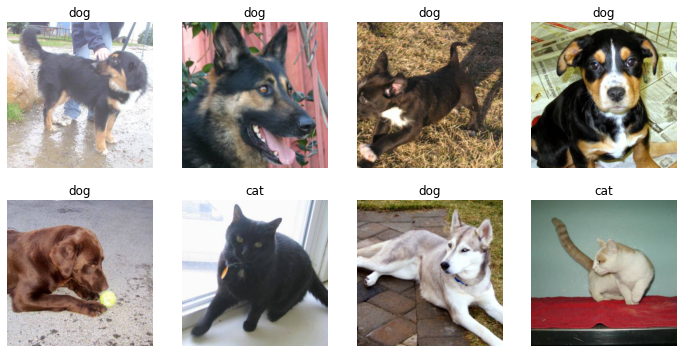

In [13]:
dls.show_batch()

# Testing Different Architecture

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.277297,0.063312,0.023600,07:00


epoch,train_loss,valid_loss,error_rate,time
0,0.129971,0.078369,0.028000,08:46
1,0.127895,0.048927,0.018000,08:44
2,0.060421,0.038785,0.015200,08:10
3,0.058042,0.032990,0.013200,07:53


In [15]:
# learn = vision_learner(dls, "efficientnet_b0", metrics=error_rate)
# learn.fine_tune(2)

# Model Interpretation

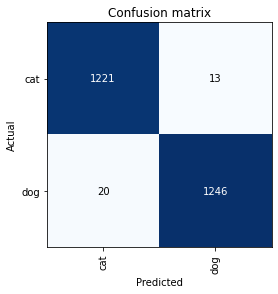

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

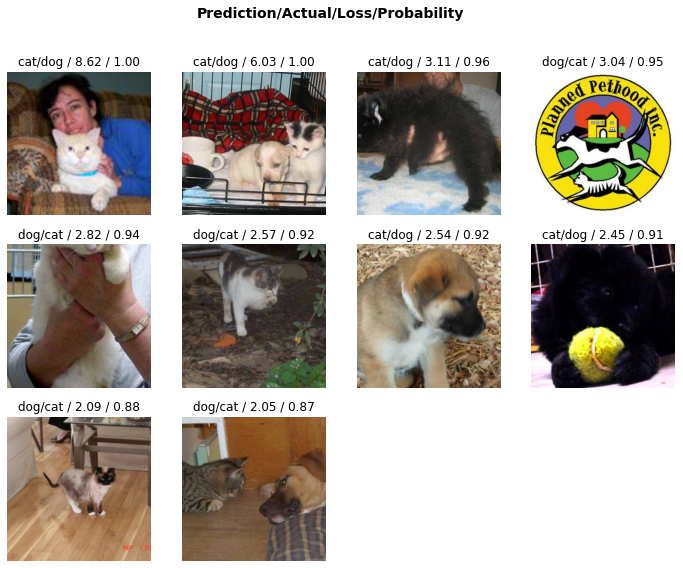

In [17]:
interp.plot_top_losses(10)

In [22]:
# predict
img = PILImage.create('data/test/1.jpg')
img.to_thumb(450,450)
learn.predict(img)

('dog', TensorBase(1), TensorBase([2.8329e-05, 9.9997e-01]))

# Prediction on test dataset

In [23]:
# creating test dataloader
test_dl = learn.dls.test_dl(get_image_files(path/'test'))

In [34]:
%%time
preds, _ = learn.get_preds(dl=test_dl)

CPU times: user 38.6 s, sys: 3.82 s, total: 42.4 s
Wall time: 2min 52s


In [35]:
# class 1 is the dog class and class 0 is the cat class
preds = preds[:,1]

(array([6109.,   61.,   36.,   32.,   24.,   24.,   36.,   35.,   83.,
        6060.]),
 array([1.6864032e-08, 9.9999957e-02, 1.9999990e-01, 2.9999983e-01,
        3.9999977e-01, 4.9999970e-01, 5.9999967e-01, 6.9999957e-01,
        7.9999954e-01, 8.9999944e-01, 9.9999940e-01], dtype=float32),
 <BarContainer object of 10 artists>)

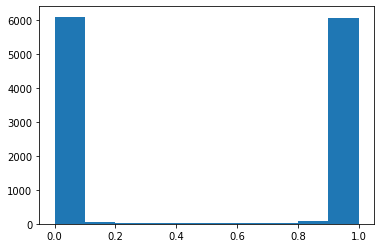

In [36]:
plt.hist(preds)

In [42]:
# creating the submission dataframe
submission_df = pd.DataFrame({'id': [int(x.stem) for x in test_dl.items], 'label': np.clip(preds, 0.005, 0.995)})
submission_df.head()

,id,label
0,9171,0.995000
1,10675,0.005000
2,11874,0.995000
3,4245,0.995000
4,2606,0.990586


In [43]:
# saving the submission dataframe
submission_df.to_csv('submission.csv', index=False)